# Pip Installs

In [2]:
%%capture

!pip install librosa
!pip install tensorflow
!pip install numpy==1.23.5
!pip install pysoundfile
!pip install alive-progress
!pip install --upgrade pytube

Tensor flow does not work with Numpy 2.0 onward so make sure that 

# Imports

Below are the necessary imports 

In [3]:
#Imports
from pydub import AudioSegment as audio
import os
import numpy as np
import librosa
#Tensor Flow needs numpy at 1.23.5
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
import re 
import soundfile as sf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from alive_progress import alive_bar
import yt_dlp

/Users/ryanbirmingham/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# File Creation

### Creating File Paths

In [4]:
unprocessed_data_dir = os.path.abspath('') + "/Unprocessed_Training_Wav_Files"
procesed_data_dir = os.path.abspath('') + "/Processed_Training_Wav_Files"

# YouTube Audio Download

In [5]:
def download_audio(url, starttime, endtime, output):
    # Convert start and end times to seconds
    hours, minutes, seconds = map(int, starttime.split(':'))
    start_time = hours * 3600 + minutes * 60 + seconds
    hours, minutes, seconds = map(int, endtime.split(':'))
    end_time = hours * 3600 + minutes * 60 + seconds
    
    """ 
    ydl_opts = {
        'format': 'bestaudio/best',  # Download the best audio format
        'postprocessors': [{
            'key': 'FFmpegExtractAudio',  # Extract audio after download
            'preferredcodec': 'wav',  # Convert to wav format
        }],
        'noplaylist': True,  # Avoid downloading playlists, download a single video
        'quiet': False,  # Show output in the terminal
        'outtmpl': 'temp_audio.%(ext)s',  # Temporary output for the full audio
    }

    #Use yt-dlp to download the audio
    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        ydl.download([url])
    """
    #Load the downloaded audio using pydub (assume the file was saved as temp_audio.wav)
    audio_file = audio.from_wav('temp_audio.wav')

    #Extract the desired clip (convert time to milliseconds)
    start_time_ms = start_time * 1000  # Convert start time from seconds to milliseconds
    end_time_ms = end_time * 1000      # Convert end time from seconds to milliseconds
    clip = audio_file[start_time_ms:end_time_ms]

    #Export the extracted clip as a new WAV file
    clip.export(output, format="wav")
    print(f"Audio clip saved to {output}")

    #Clean up the temporary file
    #os.remove('temp_audio.wav')

starttime = '0:45:05' 
endtime = '0:49:01'
name = 'vernBuchanan40603Clip1'
download_audio(url='https://www.youtube.com/watch?v=sWqEgdUSsBM',
               starttime=starttime,
               endtime=endtime,
               output=f'{unprocessed_data_dir}/{name}.wav')

[youtube] Extracting URL: https://www.youtube.com/watch?v=sWqEgdUSsBM
[youtube] sWqEgdUSsBM: Downloading webpage
[youtube] sWqEgdUSsBM: Downloading ios player API JSON
[youtube] sWqEgdUSsBM: Downloading mweb player API JSON
[youtube] sWqEgdUSsBM: Downloading player f8f53e1a


         player = https://www.youtube.com/s/player/f8f53e1a/player_ias.vflset/en_US/base.js
         n = jU6DBihk-zP_Bt5t8qc ; player = https://www.youtube.com/s/player/f8f53e1a/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/f8f53e1a/player_ias.vflset/en_US/base.js
         n = fCBzR1ZRbvuY9O38ATa ; player = https://www.youtube.com/s/player/f8f53e1a/player_ias.vflset/en_US/base.js


[youtube] sWqEgdUSsBM: Downloading m3u8 information
[info] sWqEgdUSsBM: Downloading 1 format(s): 251
[download] Destination: temp_audio.webm
[download] 100% of  156.19MiB in 00:00:21 at 7.27MiB/s     
[ExtractAudio] Destination: temp_audio.wav
Deleting original file temp_audio.webm (pass -k to keep)
Audio clip saved to /Users/ryanbirmingham/Downloads/Sunwater Projects/congressional_voice_classification/Unprocessed_Training_Wav_Files/vernBuchanan40603Clip1.wav


In [150]:
# Run before commit
#os.remove('temp_audio.wav')

FileNotFoundError: [Errno 2] No such file or directory: 'temp_audio.wav'

Steps
- go through all files in the unprocessed wav files
- break up all files so they are split by 1 second
- use regex to get the file name minus the .wav at the end to make new 1 second wav files
- save each of the files into the processed wav folder

Resample the unproccessed audio files for speaker recognition. This is needed for tensorflow and keras

In [ ]:
#This was a test for the fixing the audio with a single thing

"""
f_path = os.path.join(unproccessed_data_dir, "addisonWilson40173Clip1.wav")
arr, hz = librosa.load(f_path, sr = None)
new_f = librosa.resample(arr, orig_sr= hz, target_sr= 16000)
sf.write(os.path.join(unproccessed_data_dir,"new.wav"),new_f, 16000)
"""


'\nf_path = os.path.join(unproccessed_data_dir, "addisonWilson40173Clip1.wav")\narr, hz = librosa.load(f_path, sr = None)\nnew_f = librosa.resample(arr, orig_sr= hz, target_sr= 16000)\nsf.write(os.path.join(unproccessed_data_dir,"new.wav"),new_f, 16000)\n'

### Changes the Unporcessed_Wav_Files into 16000 hz

This is necessary for speaker recognition model training and feature extractions

In [154]:
for file in os.listdir(unprocessed_data_dir):
    if file != ".DS_Store":
        f_path = os.path.join(unprocessed_data_dir, file)
        arr, hz = librosa.load(f_path,sr = None)
        if hz != 16000:
            new_f = librosa.resample(arr, orig_sr = hz, target_sr = 16000)
            sf.write(f_path, new_f, 16000)

This is a test

In [155]:
f_path = os.path.join(unprocessed_data_dir, "addisonWilson40173Clip1.wav")
arr, hz = librosa.load(f_path, sr = None)
print(hz)

16000


## Remove the .DS_Store 
### This is a hiddent directory automatically created by Mac OS and causes errors

In [156]:
for folder in procesed_data_dir:
    path = os.path.join(folder, ".DS_Store")
    if folder == ".DS_Store":
        os.remove('.DS_Store')     

### Separates the files into 1 second intervals

In [157]:
for filename in os.listdir(unprocessed_data_dir):
    if filename.endswith(".wav"):
        hearing = audio.from_wav(os.path.join(unprocessed_data_dir,filename))
        speaker = filename.removesuffix(".wav")
        #name of congress person for processed_wav_files folder
        congress_name = speaker[:re.search(r"\d+",speaker).start()] 
        #start duration in milliseconds for audio recording start
        t1 = 0
        #end duration in milliseconds for audio recording start
        t2 = 1000
        #second of the clip
        second = 1
        total_time = hearing.duration_seconds*1000
        # Goes through all of the large audio files, splits them into 1 second audio files
        # and saves to the speaker name folder
        while t2 <= total_time:
            new_audio = hearing[t1:t2]
            #arr, hz = librosa.load(new_audio, sr = None)
            try:
                os.makedirs(f"{procesed_data_dir}/{congress_name}")
                new_audio.export(f"{procesed_data_dir}/{congress_name}/{speaker}_{second}.wav", format = "wav");
                #new_audio.export(f"{proccesed_data_dir}/{congress_name}/{speaker}_{second}.wav", format = "wav", parameters=["-ar", "16000"]);
            except:
                #new_audio.export(f"{proccesed_data_dir}/{congress_name}/{speaker}_{second}.wav", format = "wav", parameters=["-ar", "16000"]);
                new_audio.export(f"{procesed_data_dir}/{congress_name}/{speaker}_{second}.wav", format = "wav");
            t1 += 1000
            t2 += 1000
            second += 1

Check the Hz of a split file

In [158]:
a,b = librosa.load(os.path.abspath('')  + "/Processed_Training_Wav_Files/stephenCohen/stephenCohen40173Clip1_57.wav", sr = None)
print(b)

16000


## Feature Extraction

    The code below captures the spectral characteristics of the congress person speaking
    during the audio clip. This process mimics how people perceive and identify voices.
    The feature extraction below uses features which are derived from the Mel Scale and 
    cepstrum. These features are then used to train the model to identify patterns in 
    speaker voices. 

In [159]:
num_data = 0

for foldr in os.listdir(procesed_data_dir):
    if foldr != ".DS_Store":
        num_data += len(os.listdir(f"{procesed_data_dir}/{foldr}"))

In [160]:
def feature_extract (data_dir):
    features = []
    labels = []
    with alive_bar(num_data,force_tty=True, title='Collecting Features', bar = 'scuba') as bar: 
        for foldr in os.listdir(data_dir):
            if foldr != ".DS_Store":
                for file in os.listdir(f"{data_dir}/{foldr}"):
                    arr, hz = librosa.load(os.path.join(data_dir,foldr,file), sr = None, duration =  1)
                    mfccs = librosa.feature.mfcc(y = arr, sr = hz, n_mfcc = 13)
                    mfccs = StandardScaler().fit_transform(mfccs)
                    features.append(mfccs.T)
                    labels.append(foldr)
                    bar()
                 
                
    return np.array(features), np.array(labels)           
features, labels = feature_extract(procesed_data_dir)

### Feature Visualization

In [161]:
for feature_set, label in zip(features, labels[74:150]):
    print(f"Label: {label}, Features Shape: {feature_set.shape}")
    print(feature_set[0])  # Optionally print the actual features
    print("-" * 40)  # Separator for readability

Label: mikeThompson, Features Shape: (32, 13)
[-3.3528137  -0.19482704  0.5605791   0.75114375  0.3998014   0.27799278
  0.20368043  0.5438508   0.14133175  0.44739565 -0.05309591  0.19697066
  0.07799034]
----------------------------------------
Label: mikeThompson, Features Shape: (32, 13)
[-3.4371326   0.46019027  0.4048246   0.22184645  0.57023907  0.24012643
  0.34591293  0.1501962   0.19041981  0.27497125  0.12990695  0.28289312
  0.1656054 ]
----------------------------------------
Label: mikeThompson, Features Shape: (32, 13)
[-2.807486    2.0600498  -0.08796098 -0.2440007   0.28515172  0.35909262
 -0.03842863 -0.4238753  -0.13312358  0.18792579  0.00875466  0.5027635
  0.33113727]
----------------------------------------
Label: mikeThompson, Features Shape: (32, 13)
[-3.3978493   0.9004972   0.24603708  0.43012097  0.30901477  0.29492196
  0.1808896   0.18083605  0.19038048  0.18384118  0.16422631  0.19734816
  0.11973543]
----------------------------------------
Label: mikeTh

### Training and splitting the data

In [162]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size= .2, random_state= 42)

In [163]:
label_encoder = LabelEncoder()
label_enc = label_encoder.fit_transform(labels)

In [164]:
#Original shape shows n_samples, n_features, and n_channels
print(X_train.shape)
print(y_train.shape)

(14232, 32, 13)
(14232,)


### Reshape for SVM since it takes 2D arrays

In [165]:
X_train_SVM = X_train.reshape(X_train.shape[0], -1)
X_test_SVM = X_test.reshape(X_test.shape[0], -1)

In [166]:
print(X_train_SVM.shape)
print(y_train.shape)
#print(X_train_SVM)
print(y_train)

(14232, 416)
(14232,)
['richardMcCormick' 'bradSchneider' 'addisonWilson' ... 'brianMast'
 'dannyDavis' 'bradWenstrup']


### Trying the SVM approach

In [167]:
clm = SVC(kernel="linear", probability=True)

clm.fit(X_train_SVM,y_train)

y_predict = clm.predict(X_test_SVM)
incorrect = y_predict != y_test
print((len(y_test) - sum(incorrect))/len(y_test))

0.5276763135712279


#### Shows the probability for each label for each data set

In [168]:
prob = clm.predict_proba(X_test_SVM)
for i, arr in enumerate(prob):
    prob[i] = np.round(arr * 100,3)

#### Prints all of the probabilities for each test data point

In [169]:
#np.set_printoptions(suppress=True)
#for i in prob:
#    print(i)

#### Prints the True Value, the predicted Value, and the certainty for each test data point

In [170]:
max = 0
for i, val in enumerate(prob):
    max = np.max(val)
    print(f"The True value is {y_test[i]}\n"
          f"The Predicted value is {y_predict[i]} and is {max} certain\n")
    

The True value is lloydSmucker
The Predicted value is darinLaHood and is 34.842 certain

The True value is addisonWilson
The Predicted value is addisonWilson and is 99.16 certain

The True value is scottPerry
The Predicted value is gregStanton and is 32.598 certain

The True value is davidRouzer
The Predicted value is stephenCohen and is 37.687 certain

The True value is scottPerry
The Predicted value is aaronBean and is 35.893 certain

The True value is randyFeenstra
The Predicted value is michaelQuigley and is 36.539 certain

The True value is gregStanton
The Predicted value is samuelGraves and is 52.008 certain

The True value is kevinKiley
The Predicted value is kevinKiley and is 32.064 certain

The True value is gwenMoore
The Predicted value is earlBlumenauer and is 32.841 certain

The True value is victoriaSpartz
The Predicted value is danKildee and is 7.467 certain

The True value is earlBlumenauer
The Predicted value is lloydSmucker and is 21.114 certain

The True value is will

In [171]:
total = 0
predict = 0
real_dict = {}
pred_dict = {}

for i in labels:
    real_dict[i] = 0
    pred_dict[i] = 0

for pred, real in zip(y_predict,y_test):
    real_dict[real] += 1
    pred_dict[real] += 1 if real == pred else 0
for name in real_dict:
    print(
         f"{name} \n\taccuracy = {pred_dict[name]/real_dict[name]}" 
         f"\n\tpredict/real = {pred_dict[name]}/{real_dict[name]}"
         )

mikeThompson 
	accuracy = 0.2857142857142857
	predict/real = 10/35
michelleFischbach 
	accuracy = 0.391304347826087
	predict/real = 9/23
johnLarson 
	accuracy = 0.37037037037037035
	predict/real = 20/54
gregSteube 
	accuracy = 0.4375
	predict/real = 7/16
dannyDavis 
	accuracy = 0.7435897435897436
	predict/real = 29/39
garretGraves 
	accuracy = 0.7894736842105263
	predict/real = 60/76
eleanorNorton 
	accuracy = 0.688
	predict/real = 86/125
claudiaTenney 
	accuracy = 0.34782608695652173
	predict/real = 24/69
peteStauber 
	accuracy = 0.6341463414634146
	predict/real = 26/41
danKildee 
	accuracy = 0.5555555555555556
	predict/real = 25/45
earlBlumenauer 
	accuracy = 0.5476190476190477
	predict/real = 23/42
blakeMoore 
	accuracy = 0.48214285714285715
	predict/real = 27/56
ronEstes 
	accuracy = 0.5
	predict/real = 17/34
brandonWilliams 
	accuracy = 0.39473684210526316
	predict/real = 15/38
gregStanton 
	accuracy = 0.2549019607843137
	predict/real = 13/51
dinaTitus 
	accuracy = 0.75
	predict/r

Test Evaluation Accuracy: 0.5276763135712279


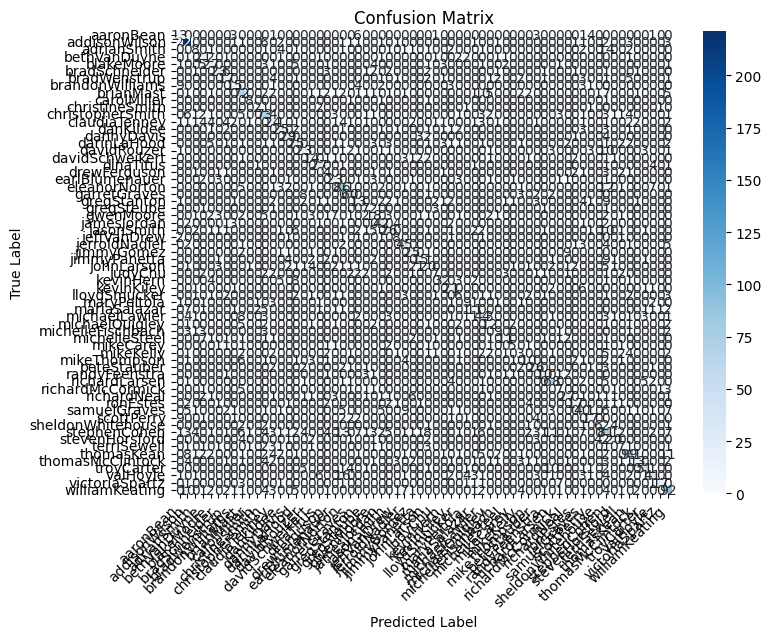

In [172]:
# Decode the labels back to original format
#y_test_decoded = label_encoder.inverse_transform(y_test)
#y_pred_decoded = label_encoder.inverse_transform(y_predict)
# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_predict, labels=np.unique(labels))

# Calculate accuracy
accuracy = accuracy_score(y_test, y_predict)
print(f"Test Evaluation Accuracy: {accuracy}")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)

# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45, ha="right")

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## Try RNN LSTM approach

### Training and testing

In [173]:
X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = train_test_split(features, label_enc, test_size=0.2, random_state=42)

In [174]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(len(np.unique(label_enc)), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
#history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)
history = model.fit(X_train_rnn, y_train_rnn, epochs=20, batch_size=32)

/Users/ryanbirmingham/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - accuracy: 0.0953 - loss: 3.7648
Epoch 2/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - accuracy: 0.3317 - loss: 2.4597
Epoch 3/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - accuracy: 0.4689 - loss: 1.8458
Epoch 4/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - accuracy: 0.5483 - loss: 1.5474
Epoch 5/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - accuracy: 0.5956 - loss: 1.3657
Epoch 6/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - accuracy: 0.6338 - loss: 1.2330
Epoch 7/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - accuracy: 0.6697 - loss: 1.1055
Epoch 8/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - accuracy: 0.6968 - loss: 0.9984
Epoch 9/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - accuracy: 0.7210 - loss: 0.9255
Epoch 10/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - accuracy: 0.7451 - loss: 0.8471
Epoch 11/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - accuracy: 0.7610 - loss: 0.7847
Epoch 12/20
445/445 ━━━━━━━━━━

112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Test Evaluation Accuracy: 0.7013205956729418


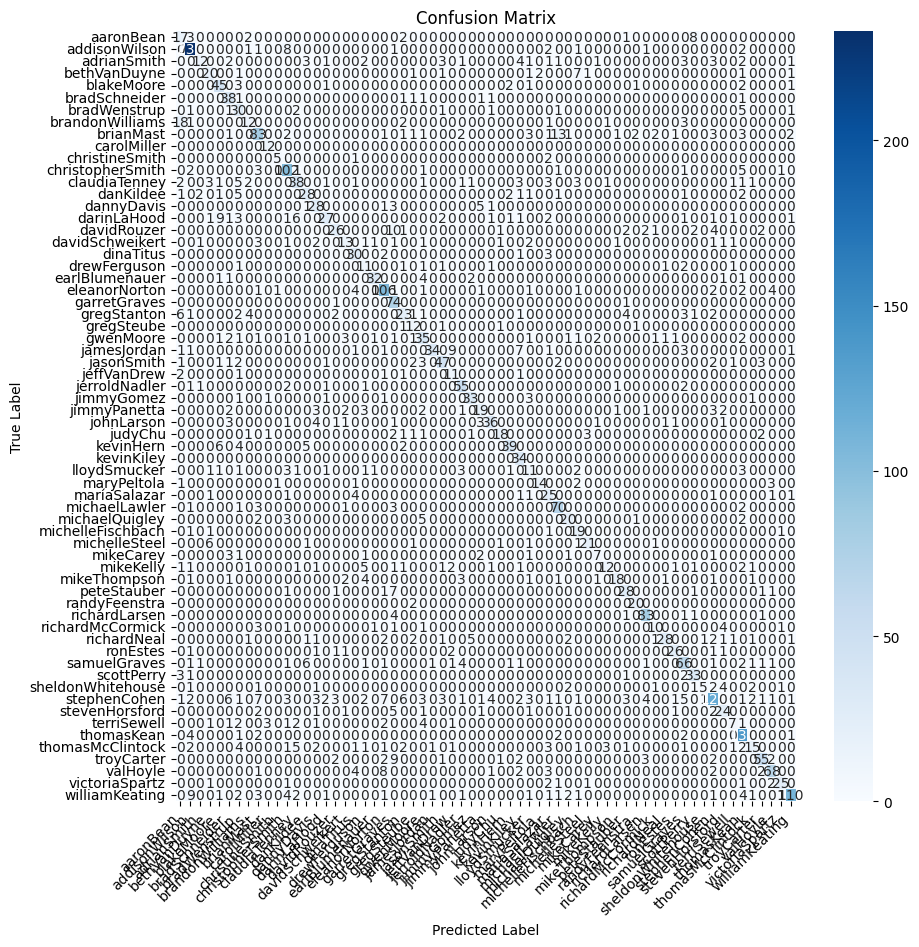

In [180]:
y_pred_probabilities = model.predict(X_test_rnn)

y_pred = np.argmax(y_pred_probabilities, axis=1)

# Decode the labels back to original format
y_test_decoded = label_encoder.inverse_transform(y_test_rnn)
y_pred_decoded = label_encoder.inverse_transform(y_pred)
# Create a confusion matrix
conf_matrix = confusion_matrix(y_test_decoded, y_pred_decoded, labels=np.unique(labels))

# Calculate accuracy
accuracy = accuracy_score(y_test_decoded, y_pred_decoded)
print(f"Test Evaluation Accuracy: {accuracy}")

plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)

# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45, ha="right")

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## Try GRU RNN approach

In [176]:
num_speakers = len(next(os.walk(procesed_data_dir))[1])

np.random.seed(42)
tf.random.set_seed(42)

y_train_one_hot = to_categorical(y_train_rnn, num_classes=num_speakers)  # n = number of speakers
y_test_one_hot = to_categorical(y_test_rnn, num_classes=num_speakers)

gru = Sequential()
gru.add(GRU(128, return_sequences = False, input_shape = (32,13))) 
gru.add(BatchNormalization())
gru.add(Dropout(.5))
gru.add(Dense(num_speakers, activation = 'softmax'))
# Compile the model
gru.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Summary of the model
gru.summary()

/Users/ryanbirmingham/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_3 (GRU)                     │ (None, 128)            │        54,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │         8,256 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,680 (248.75 KB)

 Trainable params: 63,424 (247.75 KB)

 Non-trainable params: 256 (1.00 KB)

In [177]:
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

history = gru.fit(X_train_rnn, y_train_one_hot,
                  epochs=20,
                  batch_size=32,
                  validation_data=(X_test_rnn, y_test_one_hot),
                  callbacks=[early_stopping])

Epoch 1/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - accuracy: 0.1433 - loss: 3.7835 - val_accuracy: 0.1478 - val_loss: 3.5287
Epoch 2/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - accuracy: 0.4023 - loss: 2.2354 - val_accuracy: 0.3605 - val_loss: 2.5064
Epoch 3/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - accuracy: 0.4644 - loss: 1.9720 - val_accuracy: 0.2824 - val_loss: 3.1211
Epoch 4/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - accuracy: 0.4979 - loss: 1.8033 - val_accuracy: 0.4560 - val_loss: 2.0444
Epoch 5/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - accuracy: 0.5344 - loss: 1.6444 - val_accuracy: 0.4279 - val_loss: 2.2011
Epoch 6/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - accuracy: 0.5643 - loss: 1.5243 - val_accuracy: 0.3922 - val_loss: 2.4652
Epoch 7/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - accuracy: 0.5957 - loss: 1.4123 - val_accuracy: 0.4774 - val_loss: 1.9937
Epoch 8/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - accuracy: 0.6238 - loss: 1.3395 - 

112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
3559
Test Evaluation Accuracy: 0.7620118010677156


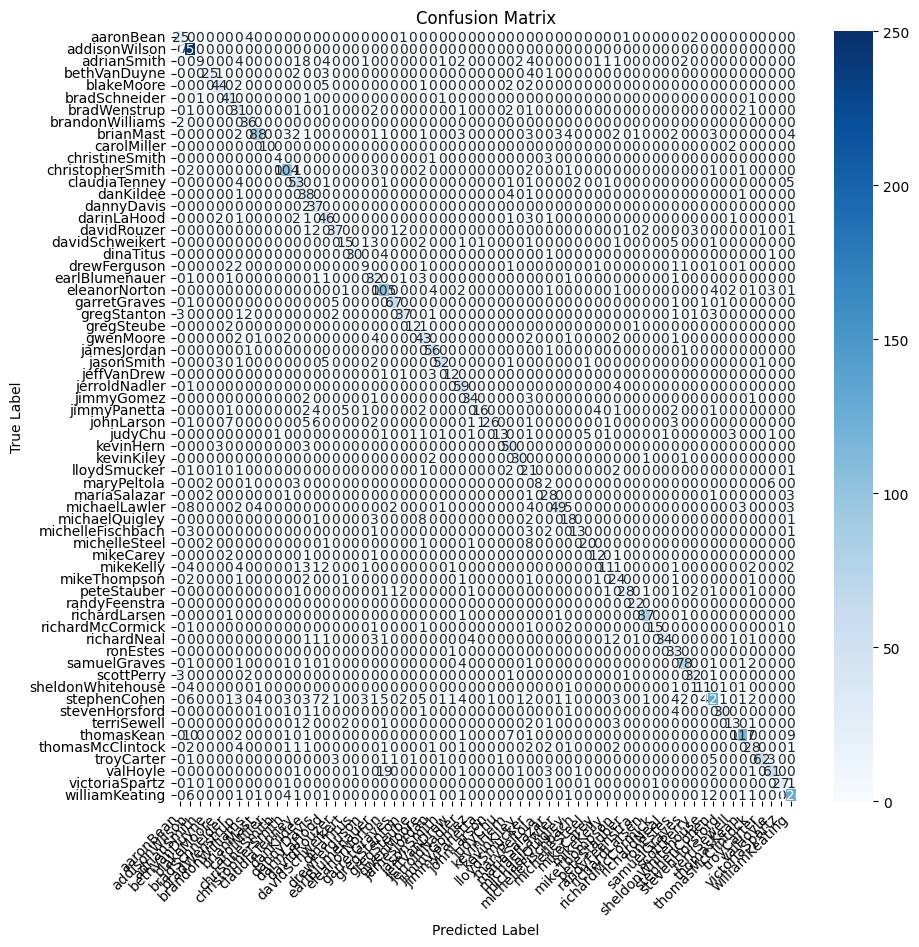

In [179]:
y_pred_probabilities = gru.predict(X_test_rnn)

y_pred = np.argmax(y_pred_probabilities, axis=1)

# Decode the labels back to original format
y_test_decoded = label_encoder.inverse_transform(y_test_rnn)
y_pred_decoded = label_encoder.inverse_transform(y_pred)
print(len(y_pred_decoded))
# Create a confusion matrix
conf_matrix = confusion_matrix(y_test_decoded, y_pred_decoded, labels=np.unique(labels))

# Calculate accuracy
accuracy = accuracy_score(y_test_decoded, y_pred_decoded)
print(f"Test Evaluation Accuracy: {accuracy}")

plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)

# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45, ha="right")

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()